In [1]:
# imports
import gymnasium as gym
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import defaultdict

In [45]:
LEFT, DOWN, RIGHT, UP = 0,1,2,3
name = 'FrozenLake-v1'
env = gym.make(name, is_slippery=False) 

In [46]:
# helper function to draw the frozen lake
def plot(env, V, policy, col_ramp=1, dpi=175, draw_vals=False):
    nrow = env.unwrapped.nrow
    ncol = env.unwrapped.ncol
    desc = env.unwrapped.desc  # array of bytes like b'S', b'F', b'H', b'G'
    nS = env.observation_space.n

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams.update({'axes.edgecolor': (0.32,0.36,0.38),
                         'font.size': 4 if nrow == 8 else 7})
    plt.figure(figsize=(3,3))
    plt.imshow(1 - V.reshape(nrow, ncol)**col_ramp,
               cmap='gray', interpolation='none', vmin=0, vmax=1)

    ax = plt.gca()
    ax.set_xticks(np.arange(ncol) - .5)
    ax.set_yticks(np.arange(nrow) - .5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for s in range(nS):
        x = s % ncol
        y = s // ncol
        a = policy[s]  # expected shape [nA]; arrows scaled by probs
        gray = np.array((0.32,0.36,0.38))
        cell = desc[y, x]

        if cell == b'G':
            plt.text(x-0.45, y-0.3, 'goal', color=(0.75,0.22,0.17), fontname='Sans', weight='bold')
            continue

        if a[0] > 0.0: plt.arrow(x, y, float(a[0])*-.84, 0.0, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)  # left
        if a[1] > 0.0: plt.arrow(x, y, 0.0, float(a[1])*.84,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)  # down
        if a[2] > 0.0: plt.arrow(x, y, float(a[2])*.84, 0.0,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)  # right
        if a[3] > 0.0: plt.arrow(x, y, 0.0, float(a[3])*-.84, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)  # up

        if cell == b'F': plt.text(x-0.45, y-0.3, 'ice',   color=(gray*V[s]), fontname='Sans')
        if cell == b'S': plt.text(x-0.45, y-0.3, 'start', color=(0.21,0.51,0.48), fontname='Sans', weight='bold')

        if draw_vals and V[s] > 0:
            vstr = f'{V[s]:.1e}' if nrow == 8 else f'{V[s]:.6f}'
            plt.text(x-0.45, y+0.45, vstr, color=(gray*V[s]), fontname='Sans')

    plt.grid(color=(0.42,0.46,0.48), linestyle=':')
    ax.set_axisbelow(True)
    ax.tick_params(color=(0.42,0.46,0.48), which='both', top=False, left=False, right=False, bottom=False)
    plt.show()

def pi_star_from_Q(Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, _ = env.reset() # start in top-left, = 0
    while not done:
        action = np.argmax(Q[state, :])
        pi_star[state,action] = 1
        state, reward, done, _, _ = env.step(action)
    return pi_star

In [47]:
# TD(0) 

num_episodes = 10000
alpha = 0.2
gamma = 1.0
V = np.zeros([env.observation_space.n])

for episode in range(1,num_episodes+1):
    s, _ = env.reset()
    while (True):
        a = np.ones(env.action_space.n, dtype=float) / env.action_space.n # random policy
        a = np.random.choice(len(a), p=a)
        next_s, reward, done, _, _ = env.step(a)
        V[s] += alpha * (reward + gamma * V[next_s] - V[s])
        if done: break
        s = next_s

In [ ]:
# helper code to plot the policy greedily obtained from TD(0) - ignore this!
policy = np.zeros([env.observation_space.n, env.action_space.n]) / env.action_space.n
for s in range(env.observation_space.n):
    q = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for prob, next_state, reward, done in env.unwrapped.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    best_a = np.argwhere(q==np.max(q)).flatten()
    policy[s] = np.sum([np.eye(env.action_space.n)[i] for i in best_a], axis=0)/len(best_a)
    
plot(env, V,policy,1.0,draw_vals=True)

In [36]:
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    A[best_action] += (1.0 - epsilon)
    return A

In [38]:
# SARSA 

Q = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 10000
gamma = 1.0
epsilon = 0.4
alpha = 0.2
stats_rewards = defaultdict(float)
stats_lengths = defaultdict(float)

for episode in range(1,num_episodes+1):
    s, _ = env.reset()
    p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
    a = np.random.choice(np.arange(len(p_a)), p=p_a)
    for t in itertools.count():
        next_s, reward, done, _, _ = env.step(a)
        p_next_a = random_epsilon_greedy_policy(Q,epsilon, next_s, env.action_space.n)
        next_a   = np.random.choice(np.arange(len(p_next_a)), p=p_next_a)
        Q[s][a] += alpha * (reward + gamma*Q[next_s][next_a] - Q[s][a])

        stats_rewards[episode] += reward
        stats_lengths[episode] = t
        if done: break
        s = next_s
        a = next_a

    if episode % 1000 == 0 and episode != 0:
        print(f"episode: {episode}/{num_episodes}")

print(f"episode: {episode}/{num_episodes}")

env.close()



episode: 1000/10000
episode: 2000/10000
episode: 3000/10000
episode: 4000/10000
episode: 5000/10000
episode: 6000/10000
episode: 7000/10000
episode: 8000/10000
episode: 9000/10000
episode: 10000/10000
episode: 10000/10000


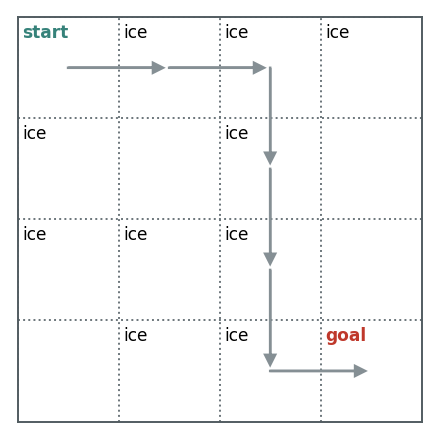

In [39]:
plot(env, np.zeros_like(Q[:,0]),pi_star_from_Q(Q))

Text(0, 0.5, 'reward (smoothed)')

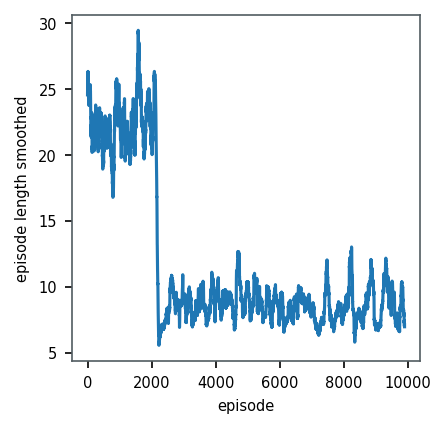

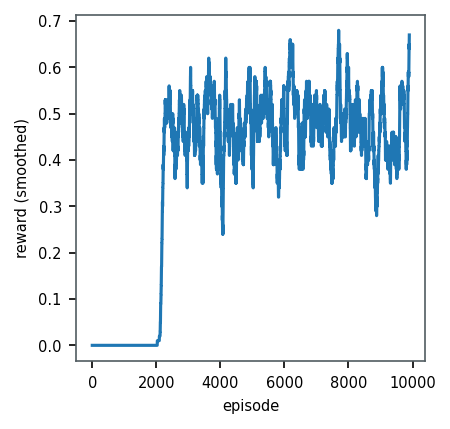

In [40]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

smoothed_lengths = moving_average(np.array(list(stats_lengths.values())))

plt.rcParams['figure.dpi'] = 150

plt.figure(1, figsize=(3,3))
plt.plot(smoothed_lengths)
plt.xlabel('episode')
plt.ylabel('episode length smoothed')

smoothed_rewards = moving_average(np.array(list(stats_rewards.values())))
plt.figure(2, figsize=(3,3))
plt.plot(smoothed_rewards)
plt.xlabel('episode')
plt.ylabel('reward (smoothed)')



episode: 1000/10000
episode: 2000/10000
episode: 3000/10000
episode: 4000/10000
episode: 5000/10000
episode: 6000/10000
episode: 7000/10000
episode: 8000/10000
episode: 9000/10000
episode: 10000/10000
episode: 10000/10000


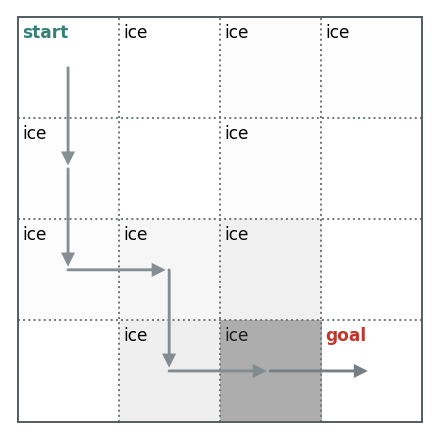

In [ ]:
# Q-learning algorithm

Q = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 10000
gamma = 1.0
epsilon = 0.4
alpha = 0.2
stats_rewards = defaultdict(float)
stats_lengths = defaultdict(float)

for episode in range(1,num_episodes+1):
    s, _ = env.reset()
    for t in itertools.count():
        p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
        a   = np.random.choice(np.arange(len(p_a)), p=p_a)
        next_s, reward, done, _, _ = env.step(a)
        Q[s][a] += alpha * (reward + gamma*np.max(Q[next_s][:]) - Q[s][a])

        stats_rewards[episode] += reward
        stats_lengths[episode] = t
        if done: break 
        s = next_s

    if episode % 1000 == 0 and episode != 0:
        print(f"episode: {episode}/{num_episodes}")

print(f"episode: {episode}/{num_episodes}")

env.close()



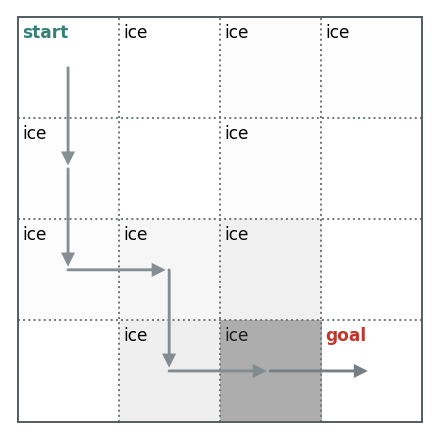

In [42]:
plot(env, V,pi_star_from_Q(Q))

Text(0, 0.5, 'reward (smoothed)')

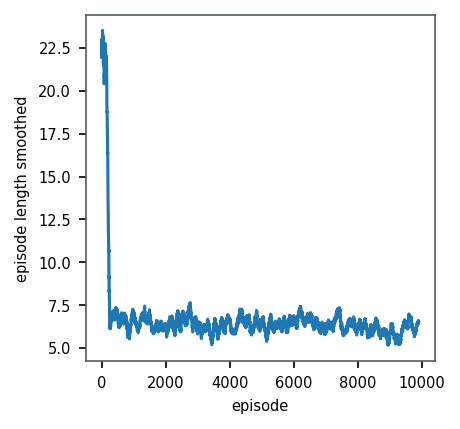

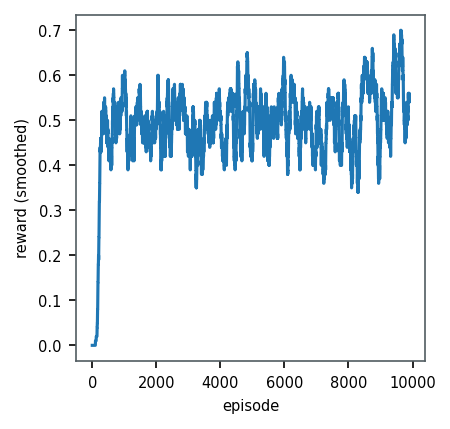

In [43]:
# plot the results
smoothed_lengths = moving_average(np.array(list(stats_lengths.values())))

plt.rcParams['figure.dpi'] = 150

plt.figure(1, figsize=(3,3))
plt.plot(smoothed_lengths)
plt.xlabel('episode')
plt.ylabel('episode length smoothed')

smoothed_rewards = moving_average(np.array(list(stats_rewards.values())))
plt.figure(2, figsize=(3,3))
plt.plot(smoothed_rewards)
plt.xlabel('episode')
plt.ylabel('reward (smoothed)')